# Optimal Unitary Gate 

This notebook will serve as a test ground for implementing an optimal unitary gate in a dissapative system.

In [199]:
# Import libraries
import numpy as np

import torch
from torch import nn
from torch.autograd import Variable

import matplotlib.pyplot as plt

In [200]:
# Define type for torch
exp_dtype = torch.complex128

# Define Pauli matrices for two level system
sigma_x = torch.tensor([[0,1],[1,0]], dtype=exp_dtype)
sigma_y = torch.tensor([[0,-1j],[1j,0]], dtype=exp_dtype)
sigma_z = torch.tensor([[1,0],[0,-1]], dtype=exp_dtype)
sigma_plus = torch.tensor([[0, 1], [0, 0]], dtype=exp_dtype)
sigma_minus = torch.tensor([[0, 0], [1, 0]], dtype=exp_dtype)
I = torch.eye(2, dtype=exp_dtype)

In [201]:
# Dice up the time
Ti, Tf = 0, 1
dt = 0.01
M = int((Tf - Ti) // dt)

# Define constants
muB = 9.27e-24 # J/T
hbar = 1.055e-34 # Js
B0 = 1e-3
kB = 1.38e-23 # J/K
Te = 0.1 # Electron temp
f_rf = 175e9 # Hz
w_rf = 2 * np.pi * f_rf
w = 2 * muB * B0 / hbar
w_rf = w

# Define control parameters
g = torch.zeros(M)
B_rf = torch.zeros(M)+0.01
phi = torch.zeros(M)
J = torch.ones(M)

g = Variable(g, requires_grad=True)
B_rf = Variable(B_rf, requires_grad=True)
phi = Variable(phi, requires_grad=True)
J = Variable(J, requires_grad=True)


In [202]:
# Helper functions to construct Lindbladian superoperator
def kron(A, B):
    return (A[:, None, :, None] * B[None, :, None, :]).reshape(A.shape[0] * B.shape[0], A.shape[1] * B.shape[1])
def hermitian_conj(A):
    return torch.conj(A).transpose(0,1)

# Define Lindblad operators
P_up = 1 / (np.exp(hbar * w / (kB * Te)) + 1)
P_down = 1 - P_up
T1 = 10000000
T2 = 10000000

L1 = np.sqrt(P_up / (2 * T1)) * sigma_plus
L2 = np.sqrt(P_down / (2 * T1)) * sigma_minus
L3 = sigma_z / (2 * np.sqrt(T2))

L = [L1, L2, L3]

L_total = torch.zeros(4, 4, dtype=exp_dtype)
for i in range(len(L)):
    L_total += 2 * kron(L[i], torch.conj(L[i])) - kron(torch.matmul(hermitian_conj(L[i]), L[i]), I) - kron(I, torch.matmul(L[i].transpose(0,1), torch.conj(L[i])))

In [203]:
# Construct superoperator
def L_F(g, B_rf, phi, J, L):
    dispersive = False
    H_rf = torch.zeros((M, 2, 2), dtype=exp_dtype)
    Gamma = torch.zeros((M, 4, 4), dtype=exp_dtype)
    for i in range(M):
        H_rf[i] = 0.5 * ((1 + g[i]/2) * w - w_rf) * sigma_z + 0.5 * (2 * muB / hbar) * B_rf[i] * (torch.cos(phi[i]) * sigma_x + torch.sin(phi[i]) * sigma_y)
        Gamma[i] = (kron(H_rf[i], I) - kron(I, H_rf[i].transpose(0,1))) + L_total if dispersive else (kron(H_rf[i], I) - kron(I, H_rf[i].transpose(0,1)))
    return torch.prod(torch.matrix_exp(-1j * Gamma * dt), dim = 0)

# Desired operator
def RX(theta):
    return torch.from_numpy(np.array([[np.cos(theta/2), -1j * np.sin(theta/2)], [-1j *
np.sin(theta/2),np.cos(theta/2)]])).type(exp_dtype)

theta = np.pi/2
UF = RX(theta)
HF = (theta/2) * sigma_x
L_desired = (kron(HF, I) - kron(I, HF.transpose(0,1))) 
L_desired = torch.matrix_exp(-1j * L_desired )


Step 0: Loss = 0.5009929301442553
Step 100: Loss = 0.6237071901559826
Step 200: Loss = 0.7814203500609613
tensor([[4.1112e-14+0.0000e+00j, 0.0000e+00-2.0209e-46j, 0.0000e+00+2.0209e-46j,
         9.9340e-79+0.0000e+00j],
        [0.0000e+00-2.0209e-46j, 4.1112e-14+0.0000e+00j, 9.9340e-79+0.0000e+00j,
         0.0000e+00+2.0209e-46j],
        [0.0000e+00+2.0209e-46j, 9.9340e-79+0.0000e+00j, 4.1112e-14+0.0000e+00j,
         0.0000e+00-2.0209e-46j],
        [9.9340e-79+0.0000e+00j, 0.0000e+00+2.0209e-46j, 0.0000e+00-2.0209e-46j,
         4.1112e-14+0.0000e+00j]], dtype=torch.complex128,
       grad_fn=<ProdBackward1>) tensor([[0.5000+0.0000j, 0.0000+0.5000j, 0.0000-0.5000j, 0.5000+0.0000j],
        [0.0000+0.5000j, 0.5000+0.0000j, 0.5000+0.0000j, 0.0000-0.5000j],
        [0.0000-0.5000j, 0.5000+0.0000j, 0.5000+0.0000j, 0.0000+0.5000j],
        [0.5000+0.0000j, 0.0000-0.5000j, 0.0000+0.5000j, 0.5000+0.0000j]],
       dtype=torch.complex128)


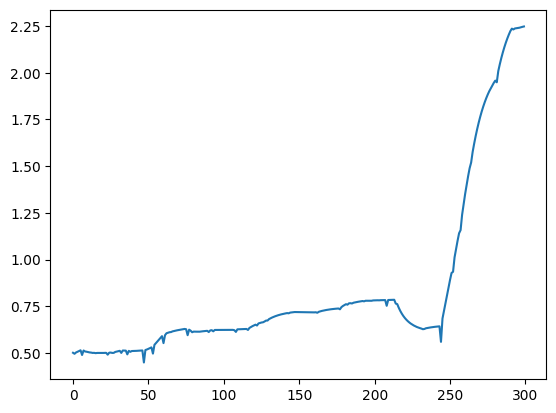

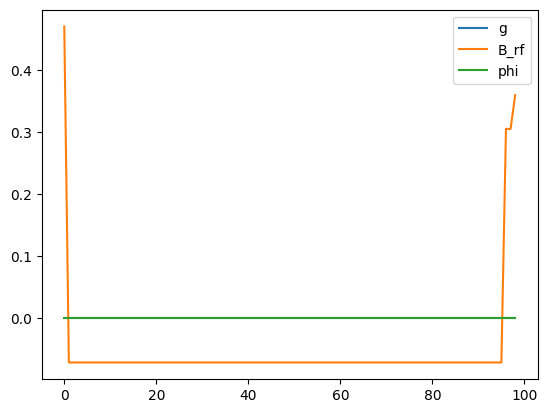

In [204]:

class CostFunction(nn.Module):
    def __init__(self):
        super(CostFunction, self).__init__()

    def forward(self, output, target, params):
        criterion = torch.nn.L1Loss()

        penalty_start_stop = 2
        cost_start_stop = 0
        for param in params:
            cost_start_stop += penalty_start_stop * torch.sum(torch.square(torch.abs(param[0])) + torch.square(torch.abs(param[-1]))).real
 
        return criterion(output, target) + penalty_start_stop
    
opt_params = [B_rf]

optimizer = torch.optim.Adam(opt_params, lr =0.015)
criterion = CostFunction()

epochs = 300

loss_array = []
for i in range(epochs):
    optimizer.zero_grad()
    L_output = L_F(g, B_rf, phi, J, L)
    loss = criterion(L_output, L_desired, opt_params)
    loss.backward()
    optimizer.step()
    loss_array.append(loss.item())
    if i % 100 == 0:

        print("Step {}: Loss = {}".format(i, loss.item()))
print(L_output, L_desired)

plt.plot(range(epochs), loss_array)
plt.show()
plt.plot(g.detach().numpy(), label="g")
plt.plot(B_rf.detach().numpy() , label = "B_rf")
plt.plot(phi.detach().numpy(), label = "phi")
plt.legend(loc='best')
plt.show()
    